## Installing & Importing Necessary Libraries

In [ ]:
pip install transformers

In [ ]:
!pip install datasets

In [ ]:
pip install nltk

In [ ]:
pip install tqdm

In [2]:
import os
import re
import pandas as pd
import requests
import time
from datetime import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from datasets import Dataset
nltk.download('punkt_tab')
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/fti_ncchethala/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fti_ncchethala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Collection

## Downloading .idx files from SEC

In [ ]:
# TO download the .idx files -- only run this if you dont have the idx files upfront
# Base URL for the SEC EDGAR full index
base_url = 'https://www.sec.gov/Archives/edgar/full-index/'

# Function to download the file, now includes headers parameter
def download_file(url, path, headers):
    with requests.get(url, headers=headers, stream=True) as r:
        r.raise_for_status()
        with open(path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Prompt for start and end year
start_year = int(input("Enter the start year (YYYY): "))
end_year = int(input("Enter the end year (YYYY): "))
save_dir = input('Please Input Path to Your Directory to Download Files:')

# Add your user-agent string here
headers = {'User-Agent': 'useremail@email.com'}

# Iterate over each year and quarter within the specified range
for year in range(start_year, end_year + 1):
    for quarter in ['QTR1', 'QTR2', 'QTR3', 'QTR4']:
        file_url = f"{base_url}{year}/{quarter}/company.idx"
        save_path = os.path.join(save_dir, f"{year}_{quarter}_company.idx")

        print(f"Attempting to download {file_url}...")

        # Make the download attempt
        try:
            download_file(file_url, save_path, headers)
            print(f"Successfully downloaded {file_url}")
        except Exception as e:
            print(f"Failed to download {file_url}. Error: {e}")

        # Respect the SEC's rate limiting
        time.sleep(1)  # Sleep for 1 second to avoid hitting rate limit

print("All requested files have been attempted to download.")

## Creating a dataframe using all the .idx files

In [ ]:
# To create the dataframe for the links from the .idx files and saving it into a csv
# Adjusting pandas display options for more optimized data viewing
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Automatically adjust display width to terminal size
pd.set_option('display.max_colwidth', None)  # Display full content of each cell

#Load data from all EDGAR index files in the specified director
def load_data_from_directory(source_dir):
    colspecs = [(0, 62), (62, 74), (74, 86), (86, 98), (98, None)]
    column_names = ['Company Name', 'Form Type', 'CIK', 'Date Filed', 'Filename']
    dataframe_collection = []

    # Iterate over each file in the directory
    for file_name in os.listdir(source_dir):
        if file_name.endswith('.idx'):  # Check for .idx files
            file_path = os.path.join(source_dir, file_name)
            try:
                # Read fixed-width file with specified columns and skip header rows
                temp_df = pd.read_fwf(file_path, colspecs=colspecs, skiprows=9, names=column_names)
                dataframe_collection.append(temp_df)
            except UnicodeDecodeError as e:
                print(f'Error reading {file_name}: {e}')
                continue
            except Exception as e:
                print(f'An unexpected error occurred while reading {file_name}: {e}')
                continue

    if not dataframe_collection:
        print("No data was loaded. Please check your file paths and names.")
        return pd.DataFrame()

    # Concatenate all DataFrames into one DataFrame
    combined_df = pd.concat(dataframe_collection, ignore_index=True)
    combined_df.columns = combined_df.columns.str.strip()  # Strip any leading/trailing whitespace from column names
    return combined_df

def save_to_csv(df, output_path):
    """Save DataFrame to a CSV file."""
    try:
        df.to_csv(output_path, index=False)
        print(f"Data saved successfully to {output_path}")
    except Exception as e:
        print(f"Failed to save the DataFrame: {e}")

# Main execution logic
if __name__ == "__main__":
    source_directory = input('Enter/path/to/data/directory: ')  # Get directory containing the data files from user
    csv_name = input('Enter the filename for the CSV (e.g., combined_data.csv): ')
    output_path = os.path.join(source_directory, csv_name)  # Construct the full path to save the CSV file

    # Load data from the specified directory
    all_data_df = load_data_from_directory(source_directory)

    # Save the data to a CSV file
    if not all_data_df.empty:
        save_to_csv(all_data_df, output_path)
    else:
        print("No data to save.")

all_data_df.head()

# Data Modeling & Pre-Processing

In [ ]:
#Load the combined_data.csv that contains the filings links of all the companies
df_idx = pd.read_csv("/home/fti_ncchethala/Python/combined_data.csv")

In [ ]:
#Load the sp500 company list
df_sp500 = pd.read_excel("/home/fti_ncchethala/Python/sp500_cik.xlsx")

In [ ]:
# Filtering only the Symbol and CIK columns of the data
df_cik = df_sp500[["Symbol","CIK"]]
df_cik.head()

In [ ]:
print(len(df_cik["CIK"]))
print(len(df_idx["CIK"]))

In [ ]:
#Making sure that both the dataframe CIK columns are of same type
df_idx['CIK']  = df_idx['CIK'].astype(str)
df_cik['CIK']  = df_cik['CIK'].astype(str)

In [ ]:
sp500_ciks = df_cik['CIK'].unique()
filtered = df_idx[df_idx['CIK'].isin(sp500_ciks)]

In [ ]:
filtered.info()

In [ ]:
unique_names= filtered["CIK"].unique()
print(len(unique_names))

## Extracting HTML contents of the page

In [ ]:
#To extract the html content from the SEC page
import requests

import pandas as pd

def extract_filing_html_directly(row, user_agent_email):
    """
    Extracts the actual 10-K filing HTML content from a row in .idx using the real HTML URL.
    """
    try:
        filename = row['Filename'].strip().replace(" ", "")
        path_parts = filename.split("/")

        if len(path_parts) < 4:
            print(f"Invalid path in Filename: {filename}")
            return None, None

        cik = path_parts[2]
        accession_with_dashes = path_parts[3]
        accession_nodashes = accession_with_dashes.replace("-", "")
        index_filename = accession_with_dashes + "-index.htm"

        index_url = f"https://www.sec.gov/Archives/edgar/data/{cik}/{accession_nodashes}/{index_filename}"
        headers = {"User-Agent": user_agent_email}

        response = requests.get(index_url, headers=headers, timeout=10)
        if response.status_code != 200:
            print(f"Failed to load index page: {index_url}")
            return None, None

        soup = BeautifulSoup(response.text, "html.parser")
        doc_table = soup.find("table", class_="tableFile")
        if doc_table is None:
            print(f"Could not find document table at: {index_url}")
            return None, None

        doc_link_tag = doc_table.find("a", href=lambda href: href and href.endswith(".htm") and not href.endswith("-index.htm"))
        if doc_link_tag is None:
            print(f"No .htm filing document found in index page: {index_url}")
            return None, None

        primary_doc = doc_link_tag['href'].lstrip("/")  # remove leading slash
        filing_url = f"https://www.sec.gov/{primary_doc}"  # FIXED — no double Archives

        filing_response = requests.get(filing_url, headers=headers, timeout=15)
        if filing_response.status_code == 200:
            print(f"Downloaded: {filing_url}")
            return filing_url, filing_response.text
        else:
            print(f"Failed to download filing from: {filing_url}")
            return filing_url, None

    except Exception as e:
        print(f"Exception occurred: {e}")
        return None, None

## Cleaning the HTML content

In [ ]:
from bs4 import BeautifulSoup

def clean_filing_html(filing_html):
    """
    Cleans the full HTML of a 10-K filing to extract readable plain text.
    Removes scripts, styles, and unnecessary whitespace.
    """
    try:
        soup = BeautifulSoup(filing_html, "html.parser")

        # Remove unwanted tags
        for tag in soup(["script", "style", "header", "footer", "nav", "noscript"]):
            tag.decompose()

        # Extract text from the body if present
        body = soup.find("body")
        raw_text = body.get_text(separator="\n") if body else soup.get_text(separator="\n")

        # Normalize whitespace
        lines = [line.strip() for line in raw_text.splitlines()]
        clean_text = "\n".join(line for line in lines if line)

        return clean_text

    except Exception as e:
        print(f" Error cleaning HTML: {e}")
        return ""

## Downloading mulitple 10 filings based on the user selection

In [ ]:
def download_multiple_10k_filings(df, user_agent_email):
    """
    Show how many 10-Ks are available, let the user choose how many to download,
    and return a DataFrame with filing metadata and text.
    """
    tenk_df = df[df['Form Type'].str.upper() == '10-K'].reset_index(drop=True)
    total = len(tenk_df)

    if total == 0:
        print("No 10-K filings found in the dataset.")
        return pd.DataFrame()

    print(f"Found {total} 10-K filings in the dataset.")
    
    while True:
        try:
            limit = int(input(f"Enter the number of 10-K filings to download (1 to {total}): "))
            if 1 <= limit <= total:
                break
            else:
                print(f"Please enter a number between 1 and {total}.")
        except ValueError:
            print("Please enter a valid integer.")

    results = []
    for idx, row in tenk_df.head(limit).iterrows():
        url, html_text = extract_filing_html_directly(row, user_agent_email)
        if html_text:
            cleaned_text = clean_filing_html(html_text)
            results.append({
                "Company Name": row['Company Name'],
                "CIK": row['CIK'],
                "Date Filed": row['Date Filed'],
                "Filing URL": url,
                "Filing Text": html_text,
                "Cleaned Text": cleaned_text
            })

    return pd.DataFrame(results)

In [ ]:
#df = pd.read_csv("/home/fti_ncchethala/Python/combined_data.csv")

### Downloading and creating the dataframe of the final cleaned text of the filings

In [ ]:
# Run the full process
filings_df = download_multiple_10k_filings(filtered, "nareshchandra.chethala@gmail.com")

# Preview results
print(filings_df[["Company Name", "Filing URL"]].head())
print("\n Sample Cleaned Filing Text:\n")
print(filings_df["Cleaned Text"][0][:2000])

### Creating the csv for the future use

In [ ]:
filings_df.to_csv("/home/fti_ncchethala/Python/sp500_filings_df.csv")

In [32]:
df_full = pd.read_csv("/home/fti_ncchethala/Python/sp500_filings_df.csv")

In [4]:
df_section = df_full[["Company Name","CIK","Date Filed","Filing Text", "Cleaned Text"]].copy()

In [5]:
df_section.head()

,Company Name,CIK,Date Filed,Filing Text,Cleaned Text
0,3M CO,66740,2014-02,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,Table of Contents\nUNITED STATES\nSECURITIES A...
1,ABBOTT LABORATORIES,1800,2014-02,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES\nSECURITIES AND EXCHANGE COMMISS...
2,ACE Ltd,896159,2014-02,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...
3,ADOBE SYSTEMS INC,796343,2014-01,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES\nSECURITIES AND EXCHANGE COMMISS...
4,ADVANCED MICRO DEVICES INC,2488,2014-02,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,Table of Contents\nUNITED STATES\nSECURITIES A...


# Section Wise Sentiment Analysis

In [6]:
def extract_10k_sections(text):
    """
    Robustly extracts Item 1, Item 7, and Item 7A sections from plain 10-K text.
    Handles common formatting variations and malformed headers.
    """
    if not isinstance(text, str) or len(text) < 100:
        return {"Item 1": "", "Item 7": "", "Item 7A": ""}

    # Lowercase to normalize matching
    text_lower = text.lower()

    # Expanded regex patterns to handle various formats and noise
    patterns = {
        "Item 1": r"(item[\s]*1[\s\.:\-–—]*((business)?[^a-z0-9]{0,10}))",
        "Item 7": r"(item[\s]*7[^a-z0-9]{0,10}(management'?s)?[^a-z0-9]{0,10}(discussion)?)",
        "Item 7A": r"(item[\s]*7a[^a-z0-9]{0,10}(quantitative)?[^a-z0-9]{0,10}(market)?[^a-z0-9]{0,10}(risk)?)"
    }

    # Match section headers with start positions
    matches = []
    for section, pattern in patterns.items():
        match = re.search(pattern, text_lower)
        if match:
            matches.append((section, match.start()))

    # Sort by appearance in the text
    matches.sort(key=lambda x: x[1])

    # Extract sections between start and next match
    sections = {}
    for i in range(len(matches)):
        name, start = matches[i]
        end = matches[i+1][1] if i + 1 < len(matches) else len(text)
        sections[name] = text[start:end].strip()

    return {
        "Item 1": sections.get("Item 1", ""),
        "Item 7": sections.get("Item 7", ""),
        "Item 7A": sections.get("Item 7A", "")
    }

In [7]:
# Applying the section level text to the dataframe
sections_df = df_section["Cleaned Text"].apply(extract_10k_sections).apply(pd.Series)

# Add the extracted sections as new columns
df_section["Item 1 Text"] = sections_df["Item 1"]
df_section["Item 7 Text"] = sections_df["Item 7"]
df_section["Item 7A Text"] = sections_df["Item 7A"]

In [11]:
# Drop rows where any of the important columns are NULL
df_section = df_section.dropna(subset=["Item 1 Text", "Item 7 Text", "Item 7A Text", "Cleaned Text"])

# Drop rows where any of the important columns are empty strings
df_section = df_section[
    (df_section["Item 1 Text"].str.strip() != "") &
    (df_section["Item 7 Text"].str.strip() != "") &
    (df_section["Item 7A Text"].str.strip() != "") &
    (df_section["Cleaned Text"].str.strip() != "")
]

# Drop rows where 'Cleaned Text' has less than 500 characters (counting spaces)
df_section = df_section[df_section["Cleaned Text"].str.len() >= 500]

# Reset index
df_section = df_section.reset_index(drop=True)

print(f"Final dataset shape: {df_section.shape}")

Final dataset shape: (509, 8)


In [12]:
print(df_section[["Item 1 Text", "Item 7 Text", "Item 7A Text"]].isnull().sum())
print(df_section[["Item 1 Text", "Item 7 Text", "Item 7A Text"]].eq("").sum())

Item 1 Text     0
Item 7 Text     0
Item 7A Text    0
dtype: int64
Item 1 Text     0
Item 7 Text     0
Item 7A Text    0
dtype: int64


In [13]:
df_section.describe()
df_section.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Company Name  509 non-null    object
 1   CIK           509 non-null    int64 
 2   Date Filed    509 non-null    object
 3   Filing Text   509 non-null    object
 4   Cleaned Text  509 non-null    object
 5   Item 1 Text   509 non-null    object
 6   Item 7 Text   509 non-null    object
 7   Item 7A Text  509 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.9+ KB


In [14]:
#df_section = df_section[["Company Name", "CIK", "Date Filed", "Item 1 Text", "Item 7 Text", "Item 7A Text"]]

In [15]:
df_section.head()

,Company Name,CIK,Date Filed,Filing Text,Cleaned Text,Item 1 Text,Item 7 Text,Item 7A Text
0,3M CO,66740,2014-02,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,Table of Contents\nUNITED STATES\nSECURITIES A...,ITEM 1\nBusiness\n3\nITEM 1A\nRisk Factors\n9\...,ITEM 7\nManagement’s Discussion and Analysis...,ITEM 7A\nQuantitative and Qualitative Disclo...
1,ABBOTT LABORATORIES,1800,2014-02,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES\nSECURITIES AND EXCHANGE COMMISS...,ITEM 1. BUSINESS\nGENERAL DEVELOPMENT OF BU...,ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSI...,ITEM 7A. QUANTITATIVE AND QUALITATIVE DISCL...
2,ACE Ltd,896159,2014-02,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...,ITEM 1.\nBusiness\n2\nITEM 1A.\nRisk Factors\n...,ITEM 7.\nManagement’s Discussion and Analysis ...,ITEM 7A.\nQuantitative and Qualitative Disclos...
3,ADOBE SYSTEMS INC,796343,2014-01,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES\nSECURITIES AND EXCHANGE COMMISS...,Item 1.\nBusiness\n3\nItem 1A.\nRisk Factors\n...,Item 7.\nManagement's Discussion and Analysis ...,Item 7A.\nQuantitative and Qualitative Disclos...
4,ADVANCED MICRO DEVICES INC,2488,2014-02,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,Table of Contents\nUNITED STATES\nSECURITIES A...,ITEM 1.\nBUSINESS\n1\nITEM 1A.\nRISK FACTORS\n...,ITEM 7.\nMANAGEMENT’S DISCUSSION AND ANALYSIS ...,ITEM 7A.\nQUANTITATIVE AND QUALITATIVE DISCLOS...


In [16]:
#Loading the Loughran-McDonald_MasterDictionary_1993-2024
lm_df = pd.read_csv("/home/fti_ncchethala/Python/Loughran-McDonald_MasterDictionary_1993-2024.csv")

In [17]:
# Filter only positive and negative words
positive_words = set(lm_df[lm_df["Positive"] > 0]["Word"].str.lower())
negative_words = set(lm_df[lm_df["Negative"] > 0]["Word"].str.lower())

In [18]:
stop_words = set(stopwords.words("english"))

def compute_lm_sentiment_percent(text):
    """
    Returns a sentiment score as a percentage:
    ((positive - negative) / total tokens) * 100
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return 0.0

    tokens = word_tokenize(text.lower())
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words]

    total = len(tokens)
    pos = sum(1 for word in tokens if word in positive_words)
    neg = sum(1 for word in tokens if word in negative_words)

    sentiment_score = (pos - neg) / total if total > 0 else 0.0
    return sentiment_score * 100

In [19]:
# Applying the sentiment analysis using Lexicon Method
df_section.loc[:, "Item1_LM_Sentiment%"] = df_section["Item 1 Text"].apply(compute_lm_sentiment_percent)
df_section.loc[:, "Item7_LM_Sentiments%"] = df_section["Item 7 Text"].apply(compute_lm_sentiment_percent)
df_section.loc[:, "Item7A_LM_Sentiments%"] = df_section["Item 7A Text"].apply(compute_lm_sentiment_percent)

In [20]:
df_section[["Company Name", "CIK","Date Filed", "Item1_LM_Sentiment%","Item7_LM_Sentiments%","Item7A_LM_Sentiments%"]].head()

,Company Name,CIK,Date Filed,Item1_LM_Sentiment%,Item7_LM_Sentiments%,Item7A_LM_Sentiments%
0,3M CO,66740,2014-02,-2.777778,0.000000,-2.020992
1,ABBOTT LABORATORIES,1800,2014-02,-3.930691,-0.781114,-1.295154
2,ACE Ltd,896159,2014-02,-2.777778,0.000000,-3.643911
3,ADOBE SYSTEMS INC,796343,2014-01,-2.777778,0.000000,-1.280525
4,ADVANCED MICRO DEVICES INC,2488,2014-02,-2.777778,0.000000,-2.023946


In [21]:
from transformers import pipeline

finbert = pipeline(
    "sentiment-analysis",
    model="yiyanghkust/finbert-tone",
    tokenizer="yiyanghkust/finbert-tone",
    device=0,
    truncation=True,
    padding=True,
    max_length=512
)

Device set to use cuda:0


In [22]:

from tqdm.notebook import tqdm
tqdm.pandas()

# Step 1: FinBERT Sentiment Function (Cleaned)
def get_finbert_sentiment(text, batch_size=16):
    """
    Breaks long text into ~3-sentence chunks, runs FinBERT on each chunk,
    and returns a single net sentiment percentage (positive% - negative%).
    """
    if not isinstance(text, str) or len(text.strip()) < 10:
        return 0.0

    from nltk.tokenize import sent_tokenize
    import numpy as np

    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return 0.0

    # Changed: Use 3-sentence chunks instead of 5
    chunks = [' '.join(sentences[i:i+3]) for i in range(0, len(sentences), 3)]

    positive = 0
    neutral = 0
    negative = 0

    for i in range(0, len(chunks), batch_size):
        batch = chunks[i:i+batch_size]
        # Skip truly empty batch
        batch = [b for b in batch if len(b.strip()) > 0]
        if not batch:
            continue
        try:
            results = finbert(batch)
            for r in results:
                label = r["label"].lower()
                if "positive" in label:
                    positive += 1
                elif "neutral" in label:
                    neutral += 1
                elif "negative" in label:
                    negative += 1
        except Exception as e:
            print("Error during FinBERT batch:", e)
            continue

    total = positive + neutral + negative

    if total == 0:
        return 0.0

    positive_pct = (positive / total) * 100
    negative_pct = (negative / total) * 100

    return positive_pct - negative_pct  # Only return net sentiment

In [23]:
# Converting Dataframe into Dataset for better usage for the section level sentiment analysis
df_finbert = Dataset.from_pandas(df_section)

In [24]:
# Step 2: Helper function for batch (corrected)
def get_batch_sentiment(text_list):
    """Efficiently get FinBERT sentiment for a list of texts."""
    scores = []
    if not text_list:
        return [0.0] * len(text_list)

    for text in text_list:
        scores.append(get_finbert_sentiment(text))
    return scores

def apply_finbert_sentiment_batch(batch):
    item1_sentiments = get_batch_sentiment(batch['Item 1 Text'])
    item7_sentiments = get_batch_sentiment(batch['Item 7 Text'])
    item7a_sentiments = get_batch_sentiment(batch['Item 7A Text'])
    
    return {
        "Item 1 FinBERT Sentiment": item1_sentiments,
        "Item 7 FinBERT Sentiment": item7_sentiments,
        "Item 7A FinBERT Sentiment": item7a_sentiments
    }

# Filtering based on text length
df_finbert = df_finbert.filter(lambda example: len(example["Cleaned Text"]) >= 500)
print(f"Dataset after length filtering: {len(df_finbert)} rows")

# Now run the optimized batch map
df_finbert = df_finbert.map(
    apply_finbert_sentiment_batch,
    batched=True,
    batch_size=32,
    num_proc=1,
    desc="Applying Section-wise FinBERT Net Sentiment"
)

Filter:   0%|          | 0/509 [00:00<?, ? examples/s]

Dataset after length filtering: 509 rows


Applying Section-wise FinBERT Net Sentiment:   0%|          | 0/509 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [25]:
df_sentiment = df_finbert.to_pandas()

In [26]:
df_sentiment[["Company Name", "CIK","Date Filed","Item 1 FinBERT Sentiment","Item 7 FinBERT Sentiment","Item 7A FinBERT Sentiment"]].head()

,Company Name,CIK,Date Filed,Item 1 FinBERT Sentiment,Item 7 FinBERT Sentiment,Item 7A FinBERT Sentiment
0,3M CO,66740,2014-02,0.000000,0.000000,2.094972
1,ABBOTT LABORATORIES,1800,2014-02,-32.835821,13.953488,-0.497512
2,ACE Ltd,896159,2014-02,0.000000,0.000000,-2.169625
3,ADOBE SYSTEMS INC,796343,2014-01,0.000000,0.000000,-2.560000
4,ADVANCED MICRO DEVICES INC,2488,2014-02,0.000000,0.000000,-10.606061


In [27]:
# Step 1: Select only needed columns
selected_columns = df_sentiment[[
    "Company Name", 
    "CIK", 
    "Date Filed", 
    "Item 1 FinBERT Sentiment", 
    "Item 7 FinBERT Sentiment", 
    "Item 7A FinBERT Sentiment"
]]

# Step 3: Save to CSV
df_sentiment.to_csv("sentiment_scores.csv", index=False)

In [28]:
pwd

'/home/fti_ncchethala'

# Applying Document level sentiment

In [36]:
# Step 1: Correct Filtering
df_full_filtered = df_full[df_full["Cleaned Text"].str.len() >= 500].copy()

print(f"Dataset after full document length filtering: {len(df_full_filtered)} rows")

Dataset after full document length filtering: 520 rows


In [38]:
df_full_filtered.head()

,Unnamed: 0,Company Name,CIK,Date Filed,Filing URL,Filing Text,Cleaned Text
0,0,3M CO,66740,2014-02,https://www.sec.gov/Archives/edgar/data/66740/...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,Table of Contents\nUNITED STATES\nSECURITIES A...
1,1,ABBOTT LABORATORIES,1800,2014-02,https://www.sec.gov/Archives/edgar/data/1800/0...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES\nSECURITIES AND EXCHANGE COMMISS...
2,2,ACE Ltd,896159,2014-02,https://www.sec.gov/Archives/edgar/data/896159...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...
3,3,ADOBE SYSTEMS INC,796343,2014-01,https://www.sec.gov/Archives/edgar/data/796343...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES\nSECURITIES AND EXCHANGE COMMISS...
4,4,ADVANCED MICRO DEVICES INC,2488,2014-02,https://www.sec.gov/Archives/edgar/data/2488/0...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,Table of Contents\nUNITED STATES\nSECURITIES A...


### Applying Lexicon method at full document level

In [39]:
df_full_filtered["LM_Sentiment%"] = df_full_filtered["Cleaned Text"].progress_apply(compute_lm_sentiment_percent)

  0%|          | 0/520 [00:00<?, ?it/s]

### Applying FinBERT at full document level

In [40]:
hf_full = Dataset.from_pandas(df_full_filtered)

In [41]:
# Step 1: Define the mapping function
def apply_finbert_full_document(batch):
    sentiments = get_batch_sentiment(batch["Cleaned Text"])
    return {
        "Full Document FinBERT Sentiment": sentiments
    }

# Step 2: Run map() on the HuggingFace Dataset
hf_full = hf_full.map(
    apply_finbert_full_document,
    batched=True,
    batch_size=32,     # ✅ Large batch size is OK on A100 GPU
    num_proc=1,        # ✅ One process, because using GPU
    desc="Applying FinBERT Sentiment at Full Document Level"
)

# Step 3: Done! View the new columns
print(hf_full.column_names)

Applying FinBERT Sentiment at Full Document Level:   0%|          | 0/520 [00:00<?, ? examples/s]

['Unnamed: 0', 'Company Name', 'CIK', 'Date Filed', 'Filing URL', 'Filing Text', 'Cleaned Text', 'LM_Sentiment%', 'Full Document FinBERT Sentiment']


In [42]:
# Step 1: Convert to Pandas
df_full_sentiment = hf_full.to_pandas()

# Step 2: Save to CSV
df_full_sentiment.to_csv("full_document_sentiment.csv", index=False)

In [43]:
df_full_sentiment.head()

,Unnamed: 0,Company Name,CIK,Date Filed,Filing URL,Filing Text,Cleaned Text,LM_Sentiment%,Full Document FinBERT Sentiment
0,0,3M CO,66740,2014-02,https://www.sec.gov/Archives/edgar/data/66740/...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,Table of Contents\nUNITED STATES\nSECURITIES A...,-2.004276,2.219140
1,1,ABBOTT LABORATORIES,1800,2014-02,https://www.sec.gov/Archives/edgar/data/1800/0...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES\nSECURITIES AND EXCHANGE COMMISS...,-1.849579,-6.209850
2,2,ACE Ltd,896159,2014-02,https://www.sec.gov/Archives/edgar/data/896159...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES SECURITIES AND EXCHANGE COMMISSI...,-3.622905,-0.880626
3,3,ADOBE SYSTEMS INC,796343,2014-01,https://www.sec.gov/Archives/edgar/data/796343...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,UNITED STATES\nSECURITIES AND EXCHANGE COMMISS...,-1.265169,-2.527646
4,4,ADVANCED MICRO DEVICES INC,2488,2014-02,https://www.sec.gov/Archives/edgar/data/2488/0...,<DOCUMENT>\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME...,Table of Contents\nUNITED STATES\nSECURITIES A...,-2.003897,-10.060060


In [45]:
# Step 1: Select only necessary columns cleanly
section_lm = df_section[[
    "Company Name", "CIK", "Date Filed",
    "Item1_LM_Sentiment%",
    "Item7_LM_Sentiments%",
    "Item7A_LM_Sentiments%"
]]

section_finbert = df_sentiment[[
    "Company Name", "CIK", "Date Filed",
    "Item 1 FinBERT Sentiment",
    "Item 7 FinBERT Sentiment",
    "Item 7A FinBERT Sentiment"
]]

full_document_sentiment = df_full_sentiment[[
    "Company Name", "CIK", "Date Filed",
    "LM_Sentiment%",   # Full-document LM
    "Full Document FinBERT Sentiment"
]]

# Step 2: Merge Section-level FinBERT and Section-level LM
merged_sections = pd.merge(section_finbert, section_lm, on=["Company Name", "CIK", "Date Filed"], how="inner")

# Step 3: Merge with Full-document level sentiments
master_sentiment = pd.merge(merged_sections, full_document_sentiment, on=["Company Name", "CIK", "Date Filed"], how="inner")

# Step 4: Check the final merged master table
print(master_sentiment.head())

                 Company Name     CIK Date Filed  Item 1 FinBERT Sentiment  \
0                       3M CO   66740    2014-02                  0.000000   
1         ABBOTT LABORATORIES    1800    2014-02                -32.835821   
2                     ACE Ltd  896159    2014-02                  0.000000   
3           ADOBE SYSTEMS INC  796343    2014-01                  0.000000   
4  ADVANCED MICRO DEVICES INC    2488    2014-02                  0.000000   

   Item 7 FinBERT Sentiment  Item 7A FinBERT Sentiment  Item1_LM_Sentiment%  \
0                  0.000000                   2.094972            -2.777778   
1                 13.953488                  -0.497512            -3.930691   
2                  0.000000                  -2.169625            -2.777778   
3                  0.000000                  -2.560000            -2.777778   
4                  0.000000                 -10.606061            -2.777778   

   Item7_LM_Sentiments%  Item7A_LM_Sentiments%  LM_Senti

In [46]:
master_sentiment.to_csv("master_sentiment.csv",index=False)

## Pearson Correlation Analysis

In [48]:
from scipy.stats import pearsonr, ttest_rel
import numpy as np

# Columns mapping: FinBERT field -> LM field
field_mapping = {
    "Item 1 FinBERT Sentiment": "Item1_LM_Sentiment%",
    "Item 7 FinBERT Sentiment": "Item7_LM_Sentiments%",
    "Item 7A FinBERT Sentiment": "Item7A_LM_Sentiments%",
    "Full Document FinBERT Sentiment": "LM_Sentiment%"
}

# Step 1: Prepare a place to store results
comparison_results = []

# Step 2: Loop over each field pair
for finbert_col, lm_col in field_mapping.items():
    
    print(f"\n📈 Comparing {finbert_col} vs {lm_col}")
    
    # Drop any rows with missing values (important)
    temp_df = master_sentiment[[finbert_col, lm_col]].dropna()
    
    # Pearson Correlation
    r, p_corr = pearsonr(temp_df[finbert_col], temp_df[lm_col])
    
    # Paired t-test
    t_stat, p_ttest = ttest_rel(temp_df[finbert_col], temp_df[lm_col])
    
    # Mean and Standard Deviation
    finbert_mean = temp_df[finbert_col].mean()
    finbert_std = temp_df[finbert_col].std()
    
    lm_mean = temp_df[lm_col].mean()
    lm_std = temp_df[lm_col].std()
    
    # Collect results
    comparison_results.append({
        "Field": finbert_col.split()[1],  # "Item 1", "Item 7" etc
        "Pearson r": r,
        "p-value (corr)": p_corr,
        "t-statistic": t_stat,
        "p-value (t-test)": p_ttest,
        "FinBERT Mean": finbert_mean,
        "FinBERT Std": finbert_std,
        "LM Mean": lm_mean,
        "LM Std": lm_std
    })

# Step 3: Convert to DataFrame
results_df = pd.DataFrame(comparison_results)

# Step 4: Print final result table
pd.set_option('display.float_format', lambda x: '%.4f' % x) 
print(results_df)


📈 Comparing Item 1 FinBERT Sentiment vs Item1_LM_Sentiment%

📈 Comparing Item 7 FinBERT Sentiment vs Item7_LM_Sentiments%

📈 Comparing Item 7A FinBERT Sentiment vs Item7A_LM_Sentiments%

📈 Comparing Full Document FinBERT Sentiment vs LM_Sentiment%
      Field  Pearson r  p-value (corr)  t-statistic  p-value (t-test)  \
0         1     0.4182          0.0000       3.2899            0.0011   
1         7     0.3453          0.0000       0.6392            0.5230   
2        7A     0.4604          0.0000     -10.3520            0.0000   
3  Document     0.4543          0.0000     -11.4415            0.0000   

   FinBERT Mean  FinBERT Std  LM Mean  LM Std  
0       -1.1582       8.5710  -2.3500  1.0972  
1       -0.1367       4.8212  -0.2674  0.7711  
2       -4.3470       5.8545  -1.7959  0.7201  
3       -4.7996       6.1798  -1.8111  0.7053  


In [49]:
results_df.to_csv("results_sentiment.csv")

## Classify Sentiment

In [50]:
# Step 1: Sentiment classification function
def classify_sentiment(score):
    if score > 2.0:
        return "Positive"
    elif score < -2.0:
        return "Negative"
    else:
        return "Neutral"

# Step 2: Apply classification for each method and section
# Full Document
master_sentiment["Full Doc FinBERT Class"] = master_sentiment["Full Document FinBERT Sentiment"].apply(classify_sentiment)
master_sentiment["Full Doc LM Class"] = master_sentiment["LM_Sentiment%"].apply(classify_sentiment)

# Section Level
master_sentiment["Item 1 FinBERT Class"] = master_sentiment["Item 1 FinBERT Sentiment"].apply(classify_sentiment)
master_sentiment["Item 1 LM Class"] = master_sentiment["Item1_LM_Sentiment%"].apply(classify_sentiment)

master_sentiment["Item 7 FinBERT Class"] = master_sentiment["Item 7 FinBERT Sentiment"].apply(classify_sentiment)
master_sentiment["Item 7 LM Class"] = master_sentiment["Item7_LM_Sentiments%"].apply(classify_sentiment)

master_sentiment["Item 7A FinBERT Class"] = master_sentiment["Item 7A FinBERT Sentiment"].apply(classify_sentiment)
master_sentiment["Item 7A LM Class"] = master_sentiment["Item7A_LM_Sentiments%"].apply(classify_sentiment)

print(master_sentiment.head())

                 Company Name     CIK Date Filed  Item 1 FinBERT Sentiment  \
0                       3M CO   66740    2014-02                    0.0000   
1         ABBOTT LABORATORIES    1800    2014-02                  -32.8358   
2                     ACE Ltd  896159    2014-02                    0.0000   
3           ADOBE SYSTEMS INC  796343    2014-01                    0.0000   
4  ADVANCED MICRO DEVICES INC    2488    2014-02                    0.0000   

   Item 7 FinBERT Sentiment  Item 7A FinBERT Sentiment  Item1_LM_Sentiment%  \
0                    0.0000                     2.0950              -2.7778   
1                   13.9535                    -0.4975              -3.9307   
2                    0.0000                    -2.1696              -2.7778   
3                    0.0000                    -2.5600              -2.7778   
4                    0.0000                   -10.6061              -2.7778   

   Item7_LM_Sentiments%  Item7A_LM_Sentiments%  LM_Senti

## Agreement Analysis
* Compare if LM and FinBERT classified the same for each filing.

In [51]:
# Step 1: Full Document Agreement
master_sentiment["Full Doc Agreement"] = (
    master_sentiment["Full Doc FinBERT Class"] == master_sentiment["Full Doc LM Class"]
)

# Step 2: Section Agreement
master_sentiment["Item 1 Agreement"] = (
    master_sentiment["Item 1 FinBERT Class"] == master_sentiment["Item 1 LM Class"]
)

master_sentiment["Item 7 Agreement"] = (
    master_sentiment["Item 7 FinBERT Class"] == master_sentiment["Item 7 LM Class"]
)

master_sentiment["Item 7A Agreement"] = (
    master_sentiment["Item 7A FinBERT Class"] == master_sentiment["Item 7A LM Class"]
)

# Step 3: Calculate agreement percentages
print("\nAgreement Rates (%):")
print("Full Document:", master_sentiment["Full Doc Agreement"].mean() * 100)
print("Item 1:", master_sentiment["Item 1 Agreement"].mean() * 100)
print("Item 7:", master_sentiment["Item 7 Agreement"].mean() * 100)
print("Item 7A:", master_sentiment["Item 7A Agreement"].mean() * 100)


Agreement Rates (%):
Full Document: 45.383104125736736
Item 1: 21.414538310412574
Item 7: 89.19449901768172
Item 7A: 51.47347740667977


## Agreement Bar Chart

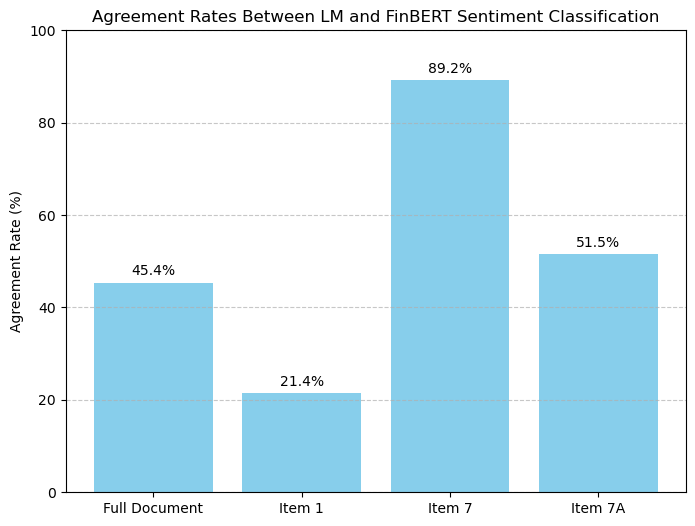

In [53]:
import matplotlib.pyplot as plt

# Step 1: Prepare Agreement Rates
agreement_rates = {
    "Full Document": master_sentiment["Full Doc Agreement"].mean() * 100,
    "Item 1": master_sentiment["Item 1 Agreement"].mean() * 100,
    "Item 7": master_sentiment["Item 7 Agreement"].mean() * 100,
    "Item 7A": master_sentiment["Item 7A Agreement"].mean() * 100
}

# Step 2: Bar Chart Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(agreement_rates.keys(), agreement_rates.values(), color="skyblue")

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)

plt.ylim(0, 100)
plt.ylabel("Agreement Rate (%)")
plt.title("Agreement Rates Between LM and FinBERT Sentiment Classification")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("agreement_bar_chart.png", dpi=300, bbox_inches='tight')
plt.show()

## Confusion Matrix (LM vs FinBERT)

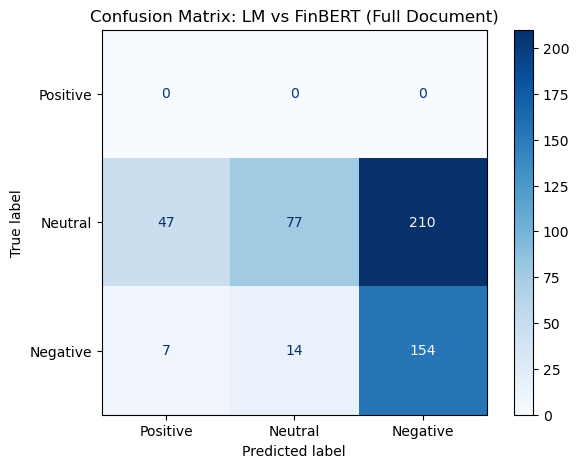

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Create confusion matrix
cm = confusion_matrix(
    master_sentiment["Full Doc LM Class"], 
    master_sentiment["Full Doc FinBERT Class"],
    labels=["Positive", "Neutral", "Negative"]  # consistent label ordering
)

# Step 2: Display confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Positive", "Neutral", "Negative"]
)

fig, ax = plt.subplots(figsize=(7, 5))
disp.plot(cmap="Blues", values_format='d', ax=ax)
plt.title("Confusion Matrix: LM vs FinBERT (Full Document)")
plt.savefig("confusion_matrix_full_doc.png", dpi=300, bbox_inches='tight')
plt.show()

## Class Distribution Bar Plots

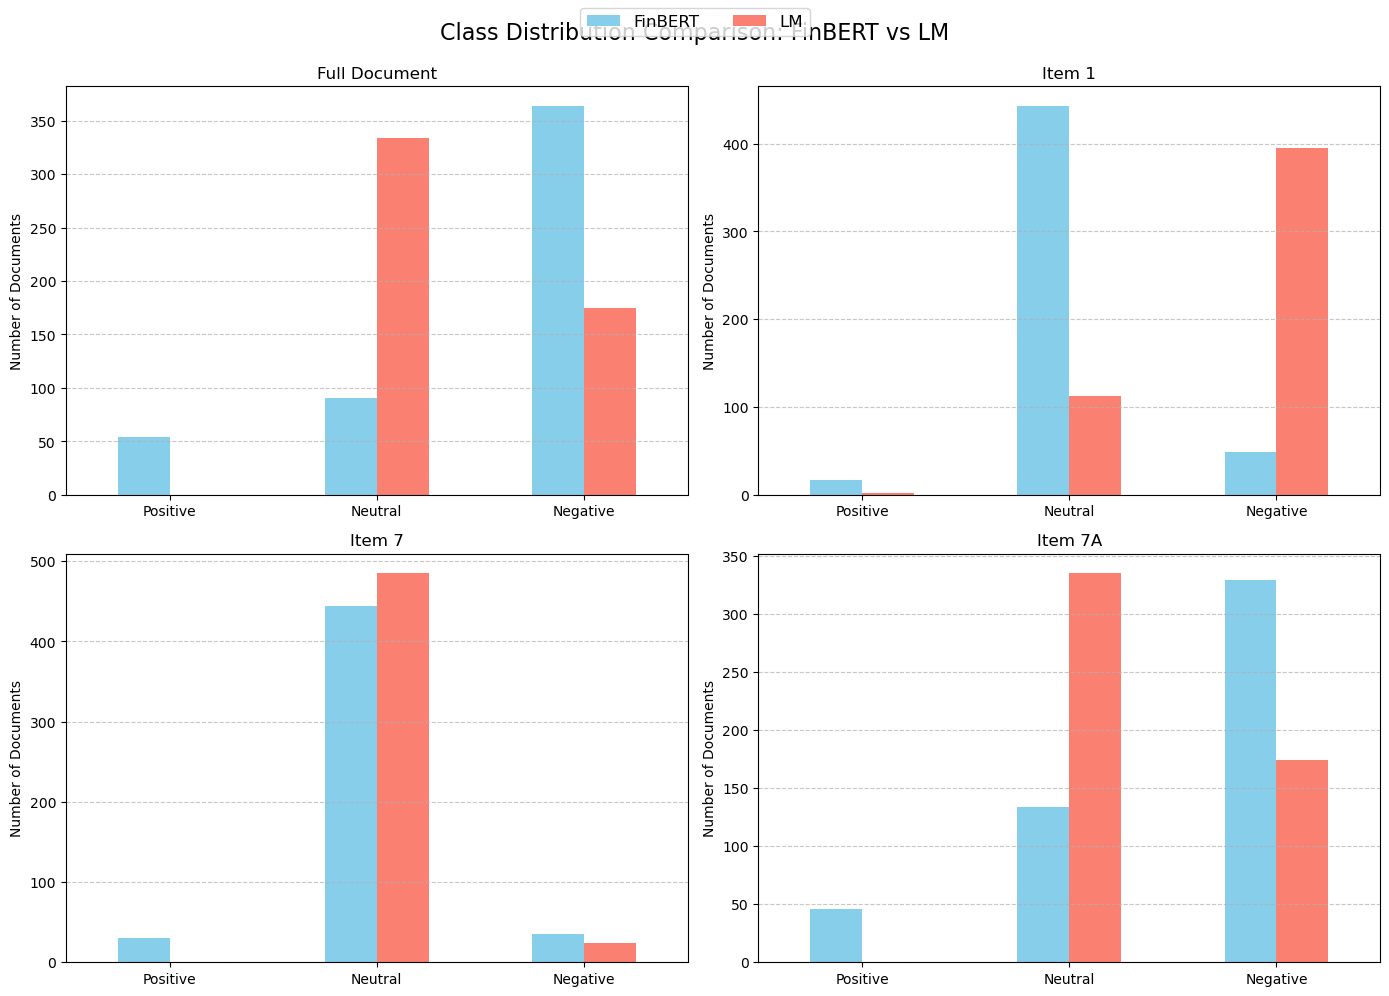

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Step 0: Make sure 'figures/' directory exists
os.makedirs("figures", exist_ok=True)

# Step 1: Define all sections
sections = {
    "Full Document": ("Full Doc FinBERT Class", "Full Doc LM Class"),
    "Item 1": ("Item 1 FinBERT Class", "Item 1 LM Class"),
    "Item 7": ("Item 7 FinBERT Class", "Item 7 LM Class"),
    "Item 7A": ("Item 7A FinBERT Class", "Item 7A LM Class")
}

# Step 2: Prepare the figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns
axes = axes.flatten()  # flatten axes for easy looping

# Step 3: Plot each section
for idx, (section_name, (finbert_col, lm_col)) in enumerate(sections.items()):
    # Count class distributions
    finbert_counts = master_sentiment[finbert_col].value_counts()
    lm_counts = master_sentiment[lm_col].value_counts()
    
    # Create comparison DataFrame
    class_distribution = pd.DataFrame({
        "FinBERT": finbert_counts,
        "LM": lm_counts
    }).reindex(["Positive", "Neutral", "Negative"])
    
    # Plot on corresponding axis
    class_distribution.plot(kind="bar", ax=axes[idx], color=["skyblue", "salmon"], legend=False)
    axes[idx].set_title(section_name)
    axes[idx].set_ylabel("Number of Documents")
    axes[idx].set_xlabel("")
    axes[idx].grid(axis='y', linestyle='--', alpha=0.7)
    axes[idx].set_xticklabels(["Positive", "Neutral", "Negative"], rotation=0)

# Step 4: Add one shared legend
fig.legend(["FinBERT", "LM"], loc="upper center", ncol=2, fontsize="large")

# Step 5: Tight layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.suptitle("Class Distribution Comparison: FinBERT vs LM", fontsize=16)
plt.savefig("figures/class_distribution_all_sections.png", dpi=300, bbox_inches='tight')
plt.show()

## Comparing All 3 different level sentiments

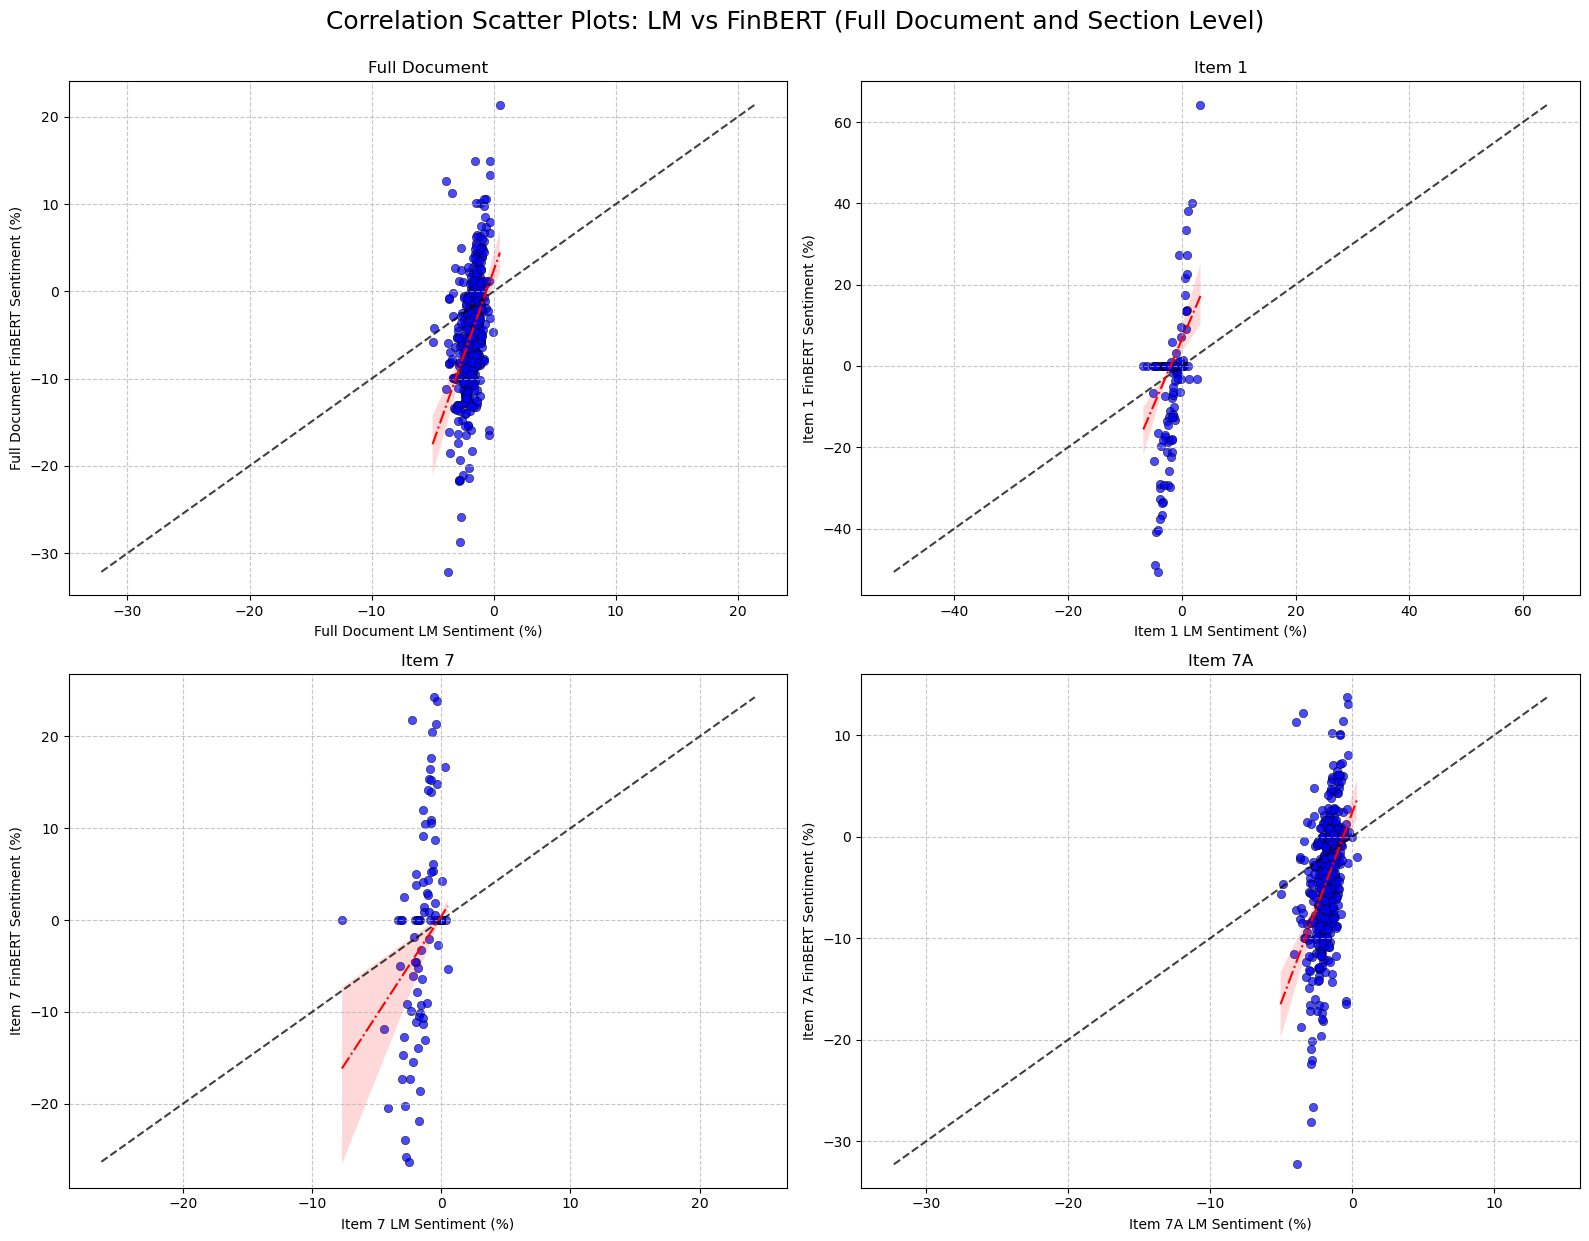

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Step 0: Make sure 'figures/' directory exists
os.makedirs("figures", exist_ok=True)

# Step 1: Define all sections and corresponding columns
sections = {
    "Full Document": ("LM_Sentiment%", "Full Document FinBERT Sentiment"),
    "Item 1": ("Item1_LM_Sentiment%", "Item 1 FinBERT Sentiment"),
    "Item 7": ("Item7_LM_Sentiments%", "Item 7 FinBERT Sentiment"),
    "Item 7A": ("Item7A_LM_Sentiments%", "Item 7A FinBERT Sentiment")
}

# Step 2: Prepare a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # flatten axes to access easily

# Step 3: Loop through each section and plot
for idx, (section_name, (lm_col, finbert_col)) in enumerate(sections.items()):
    
    # Scatter plot
    sns.scatterplot(
        x=master_sentiment[lm_col],
        y=master_sentiment[finbert_col],
        color="blue",
        edgecolor="black",
        alpha=0.7,
        ax=axes[idx]
    )
    
    # Perfect agreement line (y = x)
    lims = [
        min(master_sentiment[lm_col].min(), master_sentiment[finbert_col].min()),
        max(master_sentiment[lm_col].max(), master_sentiment[finbert_col].max())
    ]
    axes[idx].plot(lims, lims, 'k--', alpha=0.75)

    # Regression trend line
    sns.regplot(
        x=master_sentiment[lm_col],
        y=master_sentiment[finbert_col],
        scatter=False,
        color="red",
        line_kws={"linewidth":1.5, "linestyle":"-."},
        ax=axes[idx]
    )
    
    # Labels and titles
    axes[idx].set_xlabel(f"{section_name} LM Sentiment (%)")
    axes[idx].set_ylabel(f"{section_name} FinBERT Sentiment (%)")
    axes[idx].set_title(section_name)
    axes[idx].grid(True, linestyle='--', alpha=0.7)

# Step 4: Layout adjustment
plt.tight_layout()
plt.suptitle("Correlation Scatter Plots: LM vs FinBERT (Full Document and Section Level)", fontsize=18, y=1.03)
plt.savefig("figures/correlation_scatter_full_and_sections.png", dpi=300, bbox_inches='tight')
plt.show()